In [1]:
# SIFT Features
# Cosine, euclidean, etc
# BoW, VLAD
# Differnt k (# of clusters)

In [61]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from skimage.color import rgb2gray
from skimage.feature import SIFT, match_descriptors, plot_matches
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [3]:
# map
with open("data02/database/database_lite.json", "r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc = np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json", "r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    q_loc = np.array(q_idx["loc"])
with h5py.File("data02/london_lite_gt.h5", "r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

In [4]:
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image

    bow_vector = np.zeros(n_centroids)

    for i in range(n_descriptors):
        idx = np.argmin(np.linalg.norm(centroids - img_descriptors[i], axis=1), axis=0)
        bow_vector[idx] += 1
    return bow_vector

In [5]:
import pickle
# load pre-computed descriptors
f = open('data02/SIFT-descriptors-map.bin', 'rb')
descriptors = pickle.load(f)
f.close()

In [6]:
with open(os.path.join('centroids', 'K_30.npy'), 'rb') as f:
    centroids = np.load(f)

In [7]:
bow_map_images = None
sift = SIFT()
for img_name in tqdm(m_imgs):
    img = plt.imread(os.path.join('data02', img_name))
    img = rgb2gray(img)

    sift.detect_and_extract(img)
    img_descriptors = sift.descriptors  # descriptors (the feature vectors)

    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

with open(f'BoW_SIFT_K30.npy', 'wb') as f:
    np.save(f, bow_map_images)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [132]:
# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)

In [126]:
q_img_idx = 105

q_img = plt.imread(os.path.join('data02', q_imgs[q_img_idx]))
q_img = rgb2gray(q_img)

sift.detect_and_extract(q_img)
q_img_descriptors = sift.descriptors  # descriptors (the feature vectors)

bow = bag_of_words(centroids, q_img_descriptors)

distances = np.linalg.norm(bow_map_images - bow, axis=1)
idxs = np.argsort(distances)

relevant_images = np.where(sim[q_img_idx, :] == 1)[0]



# plt.imshow(q_img, cmap='gray')

[105 106 107 108 109 110]


array([477, 294, 226, 974, 408, 711, 276, 236, 407, 263, 772, 238, 429,
       469, 237, 362, 738, 728, 476, 474])

In [128]:
def precision_at_k(relevant, retrieved, k):
    tp = np.sum(np.in1d(relevant, retrieved[:k]))
    return tp / k

def average_precision(relevant, retrieved):
    # BEGIN ANSWER
    precisions = []
    for k in range(1, len(retrieved)):
        prec_at_k = precision_at_k(relevant, retrieved, k)
        precisions.append(prec_at_k)
    return sum(precisions)/len(precisions)

def mean_average_precision(all_relevant, all_retrieved):
    # BEGIN ANSWER
    total = 0
    count = len(all_retrieved)
    for qid in range(len(all_retrieved)):
        avg_precision = average_precision(all_relevant[qid], all_retrieved[qid])
        total += avg_precision
    # END ANSWER
    return total / count

In [134]:
all_relevant_images = []
all_retrieved_images = []
for query_idx in tqdm(range(len(q_imgs))):
    img = plt.imread("data02/" + q_imgs[query_idx])
    img = rgb2gray(img)
    # compute bag of words
    sift.detect_and_extract(img)
    query_img_descriptors = sift.descriptors
    bow = bag_of_words(centroids, query_img_descriptors)
    bow = scaler.transform(bow.reshape(-1, 1).transpose())
    bow = bow.transpose().reshape(-1)

    # Retrieve the indices of the top-10 similar images from the map
    retrieved_images = np.argsort(np.linalg.norm(bow_map_images - bow, axis=1))
#     print('Indices of similar images retrieved: ', retrieved_images[:10])
    all_retrieved_images.append(retrieved_images)
    # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
    relevant_images = np.where(sim[query_idx, :] == 1)[0]
#     print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)
    all_relevant_images.append(relevant_images)

mapr = mean_average_precision(all_relevant_images, all_retrieved_images)

  0%|          | 0/500 [00:00<?, ?it/s]

In [135]:
mapr

0.010391652184036801

In [130]:
q_img = plt.imread(os.path.join('data02', q_imgs[100]))
q_img = rgb2gray(q_img)
sift.detect_and_extract(q_img)
q_img_keypoints = sift.keypoints
q_img_descriptors = sift.descriptors

In [97]:
m_img = plt.imread(os.path.join('data02', m_imgs[102]))
m_img = rgb2gray(m_img)
sift.detect_and_extract(m_img)
m_img_keypoints = sift.keypoints
m_img_descriptors = sift.descriptors

0.748


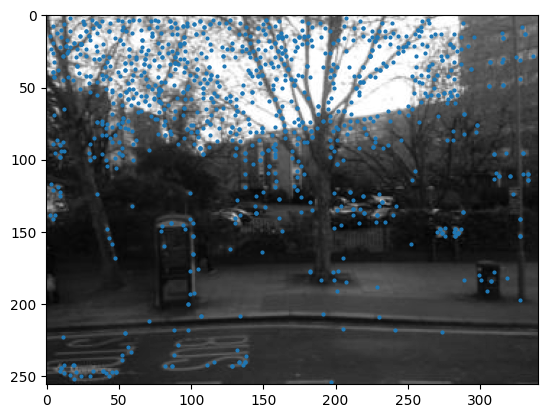

In [98]:
print(fovs[100, 103])
plt.imshow(m_img, cmap='gray')
plt.scatter(m_img_keypoints[:, 1], m_img_keypoints[:, 0], s=4)

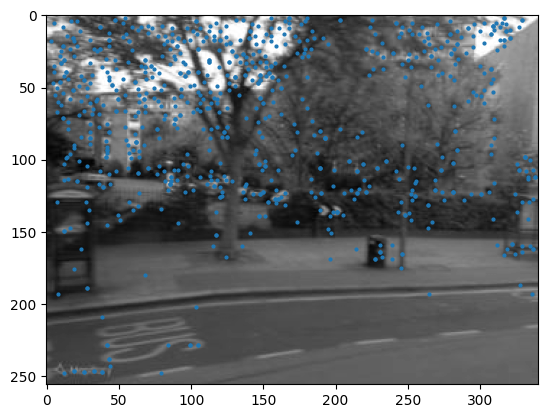

In [99]:
plt.imshow(q_img, cmap='gray')
plt.scatter(q_img_keypoints[:, 1], q_img_keypoints[:, 0], s=4)

In [100]:
fovs[0, 0]

0.7334

In [101]:
q_loc[0]

array([6.95720523e+05, 5.71145533e+06, 1.10850300e+02])

In [102]:
m_loc[0]

array([6.95725083e+05, 5.71143726e+06, 8.81663513e+01])

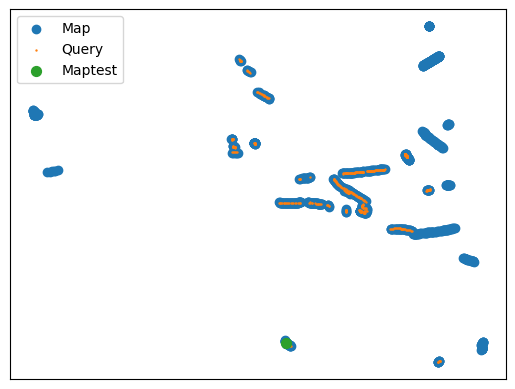

In [103]:
plt.scatter(m_loc[:,0],m_loc[:,1], label="Map")
plt.scatter(q_loc[:,0],q_loc[:,1], label="Query", s=0.5)
plt.scatter(m_loc[103,0],m_loc[103,1], label="Maptest", s=50)
# plt.scatter(q_loc[100,0],q_loc[100,1], label="Querytest", s=30)
#plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [104]:
matches = match_descriptors(m_img_descriptors, q_img_descriptors, max_ratio=0.6, cross_check=True)

Text(0.5, 1.0, 'Original Image vs. Flipped Image\n(all keypoints and matches)')

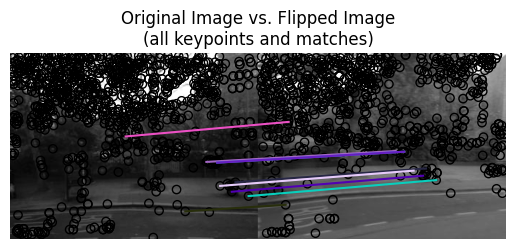

In [105]:
fig, ax = plt.subplots(1, 1)
plot_matches(ax, m_img, q_img, m_img_keypoints, q_img_keypoints, matches)
ax.axis('off')
ax.set_title("Original Image vs. Flipped Image\n"
                   "(all keypoints and matches)")

In [96]:
matches

array([[821, 746],
       [822, 414]])